# Train

## Imports

In [1]:
import magnet as mag

Accelerating your code on shiney new Tesla P100-PCIE-16GB GPU.


In [2]:
import torch

In [3]:
from captioner.nlp import get_nlp
from captioner.hparams import (vocab_size, caption_idx, shuffle, hidden_size,
                               num_layers, rnn_type, learning_rate,
                               iterations, epochs, save_every, write_every, optimzer)
from captioner.data import get_training_dataloaders
from captioner.model import Model
from captioner.train import optimize

## Preparations

In [5]:
DIR_DATA /= 'COCO'
DIR_CHECKPOINTS = DIR_MAIN / 'checkpoints'

## Get SpaCy Ready

![spaCy](../assets/spacy.png)

We use an NLP library called [spaCy](spacy.io) for tokenizing and vectorizing the captions.

This will make it easy for us to handle things like pretrained word embeddings, pruning and tokenizing easy.

The ['en_core_web_lg'](https://spacy.io/models/en#en_core_web_lg) gets the corresponding _model_ from spaCy.
It was trained as part of english multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl.

This method loads the model and then [_prunes_](https://spacy.io/api/vocab#prune_vectors) it to the ```vocab_size```. It retains the most frequent tokens and maps out of vocabulary words at runtime to synonyms.

Since this pruning takes time, the resultant vocabulary is saved as a checkpoint.

On reruns, this method loads the checkpoint if found, and then checks if the vocabulary size is the same as that requested. If not, it prunes the model as before and overwrites the existing checkpoint.

In [6]:
nlp = get_nlp('en_core_web_lg', vocab_size, DIR_CHECKPOINTS / 'vocab')

The dimension of spaCy's word embeddings

In [7]:
embedding_dim = nlp.vocab.vectors.shape[1]

## Load Data

Load the DataSets into memory and get corresponding DataLoaders for the training and validation sets as a dictionary.

The ```caption_idx``` is the index of the caption that will be generated by the DataLoader.
If negative, it selects one at random for each image.

In [8]:
dataloader = get_training_dataloaders(DIR_DATA, caption_idx, shuffle)

loading annotations into memory...
Done (t=0.98s)
creating index...
index created!
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


In [9]:
x = next(iter(dataloader['val']))

Get the size of features

In [10]:
feature_dim = x[0].shape[1]

# Create Model

![Model](../assets/model.png)
Based on [this](https://arxiv.org/abs/1411.4555) paper by [Oriol Vinyals](https://ai.google/research/people/OriolVinyals), [Alexander Toshev](https://www.linkedin.com/in/alexander-toshev-9270726), [Samy Bengio](https://ai.google/research/people/bengio) and [Dumitru Erhan](http://www.dumitru.ca/).

<br>

Made famous by [this](https://arxiv.org/abs/1412.2306v2) paper by [Andrej Karpathy](https://www.linkedin.com/in/andrej-karpathy-9a650716) and [Li Fei-Fei](https://www.linkedin.com/in/fei-fei-li-4541247).
<br>
![Karpathy's Model](../assets/karpathy.png)

The extracted features are treated as the initial hidden state of the RNN.
In order to match the dimensionality, it's first sent through a Linear layer and reshaped.

On the basis of this conditioning, the model generates it's hidden states which are further sent through a Linear layer of dimension ```vocab_size```.

Thus, at each timestep, we have a score for each possible word.

We treat this like a classification problem and use the categorical cross-entropy loss to match it to the desired _label_ at each timestep.

In [11]:
model = Model(feature_dim, embedding_dim, hidden_size,
              num_layers, rnn_type, vocab_size)

device = 'cuda:0' if mag.device == 'cuda' else mag.device
if (DIR_CHECKPOINTS / 'model.pt').exists():
    model.load_state_dict(torch.load(DIR_CHECKPOINTS / 'model.pt', map_location=device))

# Train

When these papers were first published, Adam was not known.

I've found good results using Adam with AMSGrad.
None of the embellishments (like gradient clipping) were found to be necessary.

In [12]:
optimizer = hparams.optimizer(model.parameters(), learning_rate)
if (DIR_CHECKPOINTS / 'optimizer.pt').exists():
    optimizer.load_state_dict(torch.load(DIR_CHECKPOINTS / 'optimizer.pt', map_location=device))

In [1]:
# This object holds the history of training.
history = {'iterations': 0, 'loss': [], 'val_loss': []}

In [ ]:
optimize(model, optimizer, history, dataloader, nlp, vocab_size, DIR_CHECKPOINTS,
         epochs, iterations, save_every, write_every)

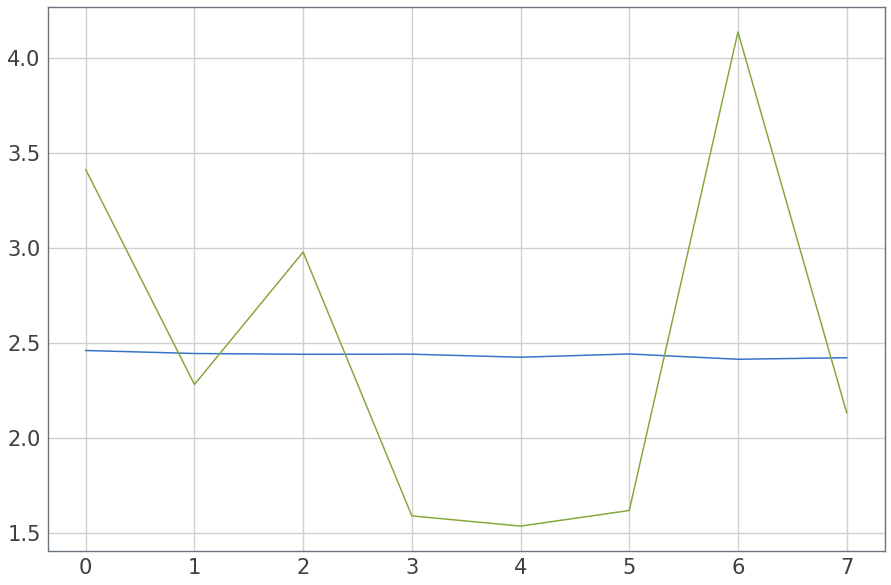

In [15]:
plot(history['loss'], label='loss')
plot(history['val_loss'], label='val_loss')

The [perplexity](https://stats.stackexchange.com/questions/10302/what-is-perplexity) is simply the exponential of the cross-entropy.

It can be roughly interpreted as the number of sides in a fair dice, which when rolled, would produce a sequence (caption) with the same entropy as ours.

The fewer the better (obviously).

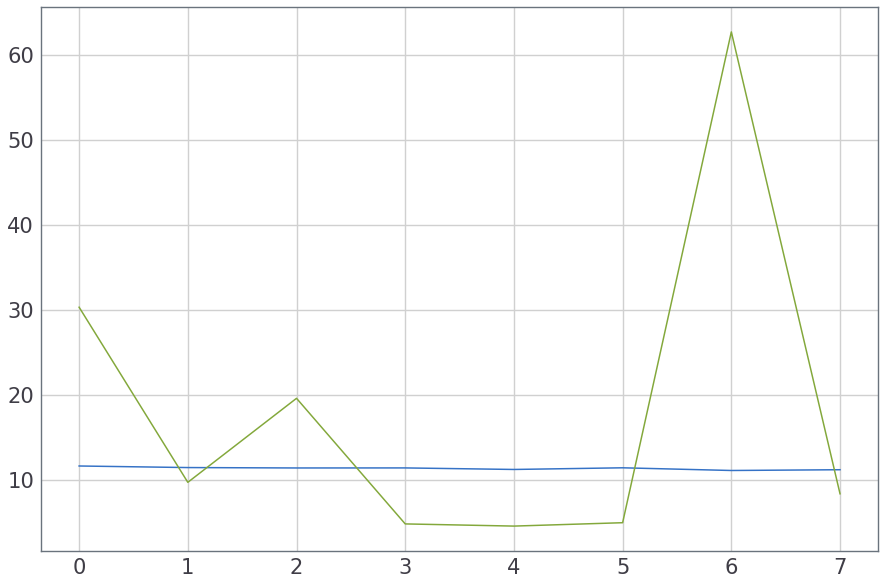

In [16]:
plot(np.exp(np.array(history['loss'])), label='perplexity')
plot(np.exp(np.array(history['val_loss'])), label='val_perplexity')